In [115]:
from plot_lib import *
from experiment_lib import load_constants_from_config
import json

In [5]:
# parse config
path = "exp-configs/europarl/100/config-125M-nl.json"

with open(path, "r") as f:
    config = json.load(f)

# Load constants from config
(
    ROOT_DIR, 
    DATASET_DIR, 
    SOURCE_DIR, 
    DATASET_NAME, 
    EXPERIMENT_NAME, 
    NUM_TRIALS, 
    PREFIX_LEN, 
    SUFFIX_LEN, 
    PREPREFIX_LEN, 
    LANGUAGE, 
    SPLIT, 
    EXAMPLE_TOKEN_LEN, 
    SOURCE_FILE, 
    BATCH_SIZE, 
    MODEL_NAME, 
    TRAIN_FILE, 
    VAL_FILE, 
    VAL_SPLIT, 
    SEED
) = load_constants_from_config(config)

tmp/europarl/nl/nl-100-100-125M/bleu_scores/sorted_compl_bleu_scores.jsonl
[{'exid': '81', 'scores': [{'trial': 89, 'score': 0.09165155901991762}, {'trial': 82, 'score': 0.07144376414907924}, {'trial': 9, 'score': 0.06586156404736743}, {'trial': 11, 'score': 2.67840658115524e-78}, {'trial': 67, 'score': 2.5958947962503744e-78}, {'trial': 36, 'score': 2.4550457214087744e-78}, {'trial': 41, 'score': 2.415752311108415e-78}, {'trial': 60, 'score': 2.381477637490544e-78}, {'trial': 6, 'score': 2.1828786285426795e-78}, {'trial': 54, 'score': 2.1828786285426795e-78}, {'trial': 42, 'score': 2.1261319621922862e-78}, {'trial': 69, 'score': 2.106166070821089e-78}, {'trial': 15, 'score': 2.0856156518980804e-78}, {'trial': 93, 'score': 2.0590418737165187e-78}, {'trial': 47, 'score': 2.0313974585519703e-78}, {'trial': 28, 'score': 1.9473215746536094e-78}, {'trial': 10, 'score': 1.9408840598757162e-78}, {'trial': 49, 'score': 1.8939194563095452e-78}, {'trial': 79, 'score': 1.872675878931853e-78}, {'t

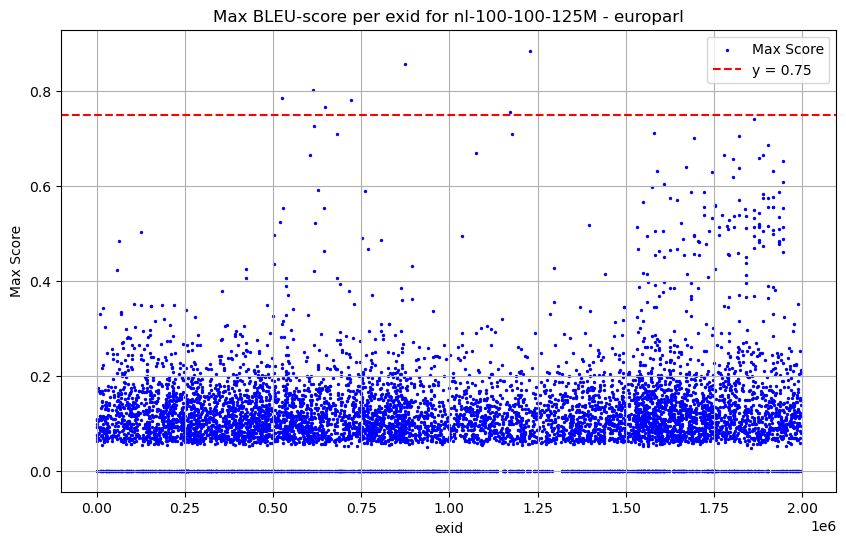

In [116]:
plot_max_BLEU(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

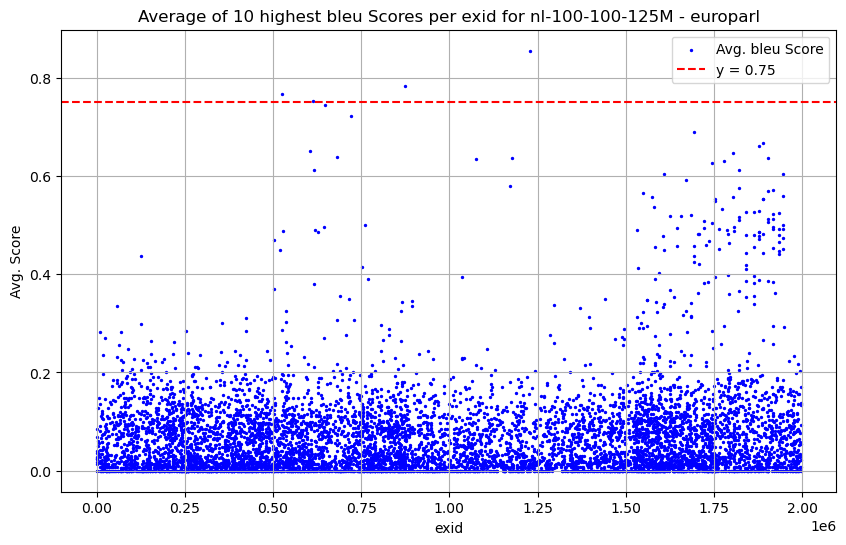

In [8]:
avg_10_highest_score(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS, isMeteor=False)

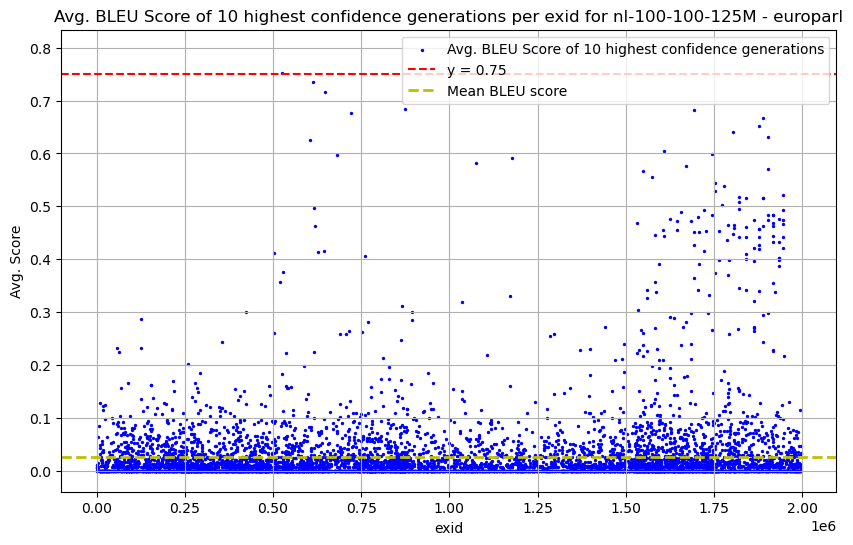

In [10]:
avg_10_highest_conf(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


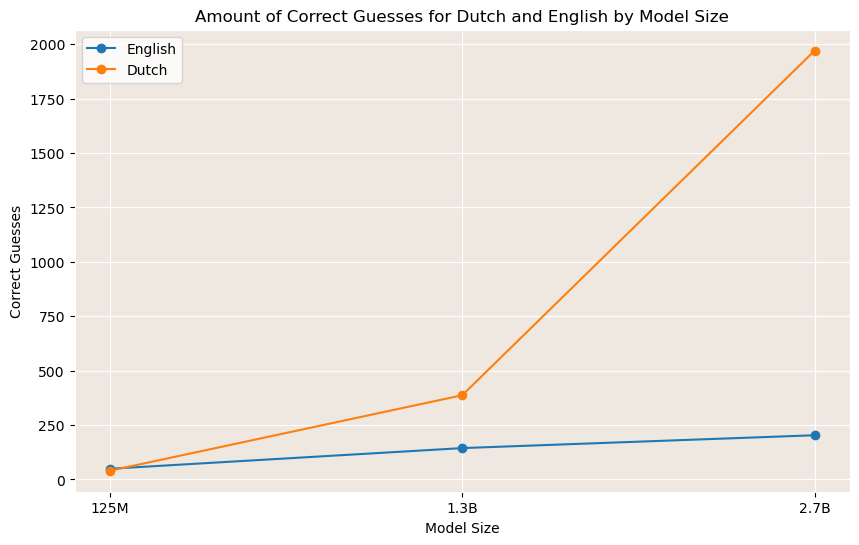

In [111]:
# Get the Wandb API key from environment variable
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize Wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Number of correct guesses for model sizes and languages - " + DATASET_DIR,
    config={
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B"]
languages = ["en", "nl"]

en_scores = []
nl_scores = []

for lang in languages:
    for size in model_sizes:
        acc_file = os.path.join(base, lang, f"{lang}-{EXAMPLE_TOKEN_LEN}-{NUM_TRIALS}-{size}", "accuracy.jsonl")
        with open(acc_file, 'r') as file:
            # Load the first line
            data = json.loads(file.readline())

            # Get the number of correct guesses
            correct = data['num_correct']
            exact = data['num_exact_match']
            if lang == "en":
                en_scores.append((size, correct, exact))
            if lang == "nl":
                nl_scores.append((size, correct, exact))

# Convert scores to a format suitable for Wandb Table
table = wandb.Table(columns=["Model Size", "Correct Guesses", "Exact Matches", "Language"])
for size, correct, exact in en_scores:
    table.add_data(size, correct, exact, "English")
for size, correct, exact in nl_scores:
    table.add_data(size, correct, exact, "Dutch")

# Log the table to Wandb
wandb.log({"Correct Guesses Comparison": table})

# Create plot
wandb.log({
    "Correct guesses comparison": wandb.plot.line_series(
        xs=[[size] for size, _, _ in en_scores] + [[size] for size, _, _ in nl_scores],
        ys=[[correct] for _, correct, _ in en_scores] + [[correct] for _, correct, _ in nl_scores],
        keys=["English"] * len(en_scores) + ["Dutch"] * len(nl_scores),
        title="Amount of Correct Guesses for Dutch and English by Model Size",
    )
})

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([size for size, _, _ in en_scores], [correct for _, correct, _ in en_scores], label='English', marker='o')
ax.plot([size for size, _, _ in nl_scores], [correct for _, correct, _ in nl_scores], label='Dutch', marker='o')
ax.set_xlabel('Model Size')
ax.set_ylabel('Correct Guesses')
ax.set_title('Amount of Correct Guesses for Dutch and English by Model Size')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')  # Set the background color
ax.set_xticks(model_sizes)
ax.set_xticklabels(['125M', '1.3B', '2.7B'])


    # Set the color of the spines to white
for spine in ax.spines.values():
    spine.set_edgecolor('white')
# Log the figure to Wandb
wandb.log({"Correct Guesses Comparison Figure": wandb.Image(fig)})

# Show the plot
plt.show()


# Finish the Wandb run
wandb.finish()

In [57]:
exp_name = "nl-100-100-2.7B"

acc_path = os.path.join("tmp/europarl/nl", exp_name, "accuracy.jsonl")
losses_base = os.path.join("tmp/europarl/nl", exp_name, "losses/decoded")

losses_file_pattern = os.path.join(losses_base, "decoded_losses_trial_")

with open(acc_path, 'r') as file:

    lines = file.readlines()
    # Load the first line
    data = json.loads(lines[0])

    # Get the number of correct guesses
    correct = data['num_correct']
    exact = data['num_exact_match']
    print(f"Number of correct guesses: {correct}")
    print(f"Number of exact matches: {exact}")

    losses_total = []

    for line in lines[1:]:
        data = json.loads(line)
        print(data)
        exid = data['exid']
        correct = data['trials_correct']
        losses = []

        for trial in correct:
            trial_num = trial['trial']
            # load the loss from loss file
            with open(f"{losses_file_pattern}{trial_num}.jsonl", 'r') as loss_file:
                lines = loss_file.readlines()
                for line in lines:
                    loss_data = json.loads(line)
                    if str(loss_data['exid']) == exid:
                        loss = loss_data['loss']
                        losses.append({
                            "trial": trial_num,
                            "loss": loss
                        })
        
        losses_total.append({
            "exid": exid,
            "losses": losses
        })

    # save losses_total
    with open(os.path.join("tmp/europarl/nl", exp_name, "correct_guess_losses.jsonl"), 'w') as file:
        for item in losses_total:
            file.write(json.dumps(item) + "\n")

Number of correct guesses: 1970
Number of exact matches: 141
{'exid': '1965857', 'num_correct': 50, 'num_exact_match': 6, 'trials_correct': [{'trial': 7, 'score': 1.0}, {'trial': 11, 'score': 1.0}, {'trial': 50, 'score': 1.0}, {'trial': 60, 'score': 1.0}, {'trial': 71, 'score': 1.0}, {'trial': 93, 'score': 1.0}, {'trial': 5, 'score': 0.958740481558872}, {'trial': 13, 'score': 0.958740481558872}, {'trial': 14, 'score': 0.958740481558872}, {'trial': 20, 'score': 0.958740481558872}, {'trial': 23, 'score': 0.958740481558872}, {'trial': 27, 'score': 0.958740481558872}, {'trial': 31, 'score': 0.958740481558872}, {'trial': 41, 'score': 0.958740481558872}, {'trial': 44, 'score': 0.958740481558872}, {'trial': 45, 'score': 0.958740481558872}, {'trial': 53, 'score': 0.958740481558872}, {'trial': 54, 'score': 0.958740481558872}, {'trial': 58, 'score': 0.958740481558872}, {'trial': 59, 'score': 0.958740481558872}, {'trial': 69, 'score': 0.958740481558872}, {'trial': 88, 'score': 0.926934323706186},

In [102]:
import json
import matplotlib.pyplot as plt

# Filepaths to your JSONL files
filepath_losses = os.path.join("tmp/europarl/nl", exp_name, "correct_guess_losses.jsonl")
filepath_scores = os.path.join("tmp/europarl/nl", exp_name, "accuracy.jsonl")

# Initialize dictionaries to hold the data
losses_dict = {}
scores_dict = {}

# Load the data from the losses JSONL file
with open(filepath_losses, 'r') as file:
    for line in file:
        data = json.loads(line)
        for item in data['losses']:
            losses_dict[(data['exid'], item['trial'])] = item['loss']

# Load the data from the scores JSONL file
with open(filepath_scores, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        data = json.loads(line)
        print(data)
        for item in data['trials_correct']:
            scores_dict[(data['exid'], item['trial'])] = item['score']

# Create lists for plotting
exids = []
trials = []
losses = []
scores = []

for key in losses_dict.keys():
    if key in scores_dict:
        exids.append(key[0])
        trials.append(key[1])
        losses.append(losses_dict[key])
        scores.append(scores_dict[key])

# Create the plot
plt.figure(figsize=(10, 6))
for exid, trial, score, loss in zip(exids, trials, scores, losses):
    plt.scatter(loss, score, label=f'exid: {exid}')
plt.ylabel('Score')
plt.xlabel('Loss')
plt.title('Loss vs Score: ' + exp_name)
plt.grid(True)
plt.show()

{'exid': '83', 'scores': [{'trial': 94, 'score': 0.08032354490095452}, {'trial': 78, 'score': 0.07918391511662133}, {'trial': 7, 'score': 0.07047448671491263}, {'trial': 30, 'score': 0.06957653920684007}, {'trial': 38, 'score': 0.06446239417777984}, {'trial': 80, 'score': 1.9517452248976023e-78}, {'trial': 59, 'score': 1.8196578122273207e-78}, {'trial': 32, 'score': 1.6933824019618624e-78}, {'trial': 41, 'score': 1.6933824019618624e-78}, {'trial': 52, 'score': 1.6933824019618624e-78}, {'trial': 50, 'score': 1.6679107487892666e-78}, {'trial': 51, 'score': 1.6679107487892666e-78}, {'trial': 79, 'score': 1.6412155631049244e-78}, {'trial': 48, 'score': 1.5301437312903484e-78}, {'trial': 39, 'score': 1.5071274944483796e-78}, {'trial': 36, 'score': 1.4830056711772711e-78}, {'trial': 3, 'score': 1.4308886378873425e-78}, {'trial': 43, 'score': 1.4308886378873425e-78}, {'trial': 74, 'score': 1.4308886378873425e-78}, {'trial': 99, 'score': 5.933924816374188e-155}, {'trial': 64, 'score': 5.849734

KeyError: 'trials_correct'

In [91]:
filepath_losses = os.path.join("tmp/europarl/nl", exp_name, "correct_guess_losses.jsonl")

out_file = 'tmp/europarl/nl/average_loss.jsonl'

# load all values in file
with open(filepath_losses, 'r') as file:
    lines = file.readlines()
    
    # load all losses in a list
    losses = []
    for line in lines:
        data = json.loads(line)
        for item in data['losses']:
            losses.append(item['loss'])


    avg = sum(losses) / len(losses)

    print(f"Average loss: {avg}")

with open(out_file, 'a') as file:
    file.write(json.dumps({"experiment_name": exp_name,
                           "average_loss": avg}) + "\n")

Average loss: 0.15074232041949245


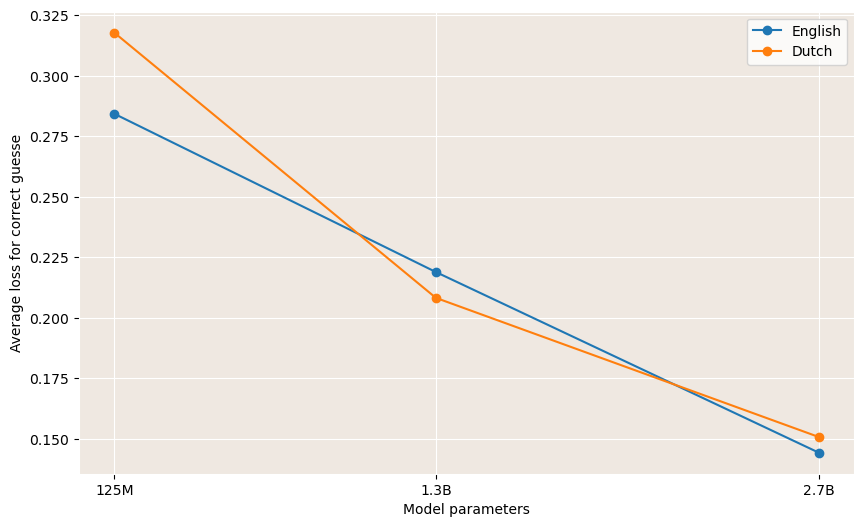

In [101]:
import json
import matplotlib.pyplot as plt
def plot_average_loss(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    # add 6B here
    model_sizes = [125000000, 1300000000, 2700000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])      

    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, average_losses_en, 'o-', label='English')
    ax.plot(model_sizes, average_losses_nl, 'o-', label='Dutch')
    ax.set_ylabel('Average loss for correct guesse')
    ax.set_xlabel('Model parameters')
    # ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    # save figure
    plt.savefig('tmp/europarl/average_loss.png')

    plt.show()




nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss(en, nl)

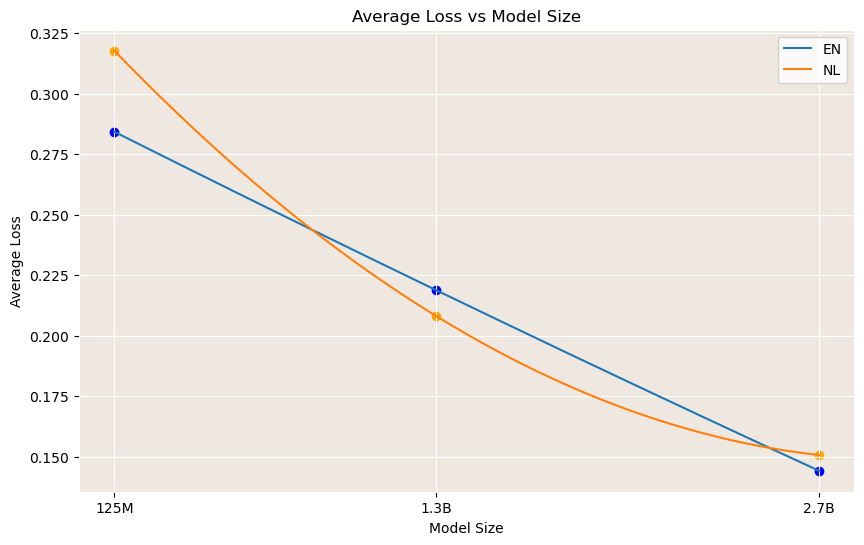

In [113]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

def plot_average_loss_interpolated(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    model_sizes = [125000000, 1300000000, 2700000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])

    # Create the cubic spline interpolation functions
    cs_en = CubicSpline(model_sizes, average_losses_en)
    cs_nl = CubicSpline(model_sizes, average_losses_nl)

    # Create an array of x values for the interpolated function
    xs = np.logspace(np.log10(min(model_sizes)), np.log10(max(model_sizes)), 500)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xs, cs_en(xs), label='EN')
    ax.plot(xs, cs_nl(xs), label='NL')
    ax.scatter(model_sizes, average_losses_en, color='blue')
    ax.scatter(model_sizes, average_losses_nl, color='orange')
    ax.set_ylabel('Average Loss')
    ax.set_xlabel('Model Size')
    ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    plt.show()

nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss_interpolated(en, nl)

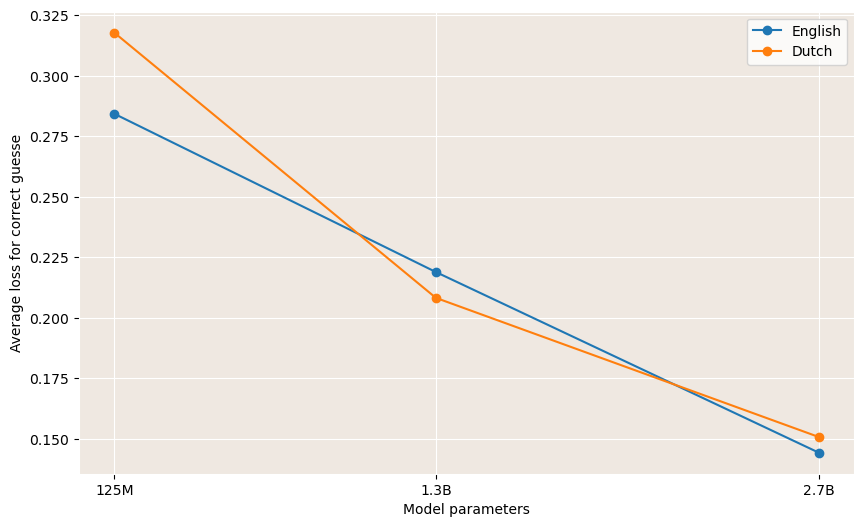

In [ ]:
import json
import matplotlib.pyplot as plt
def plot_average_loss(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    # add 6B here
    model_sizes = [125000000, 1300000000, 2700000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])      

    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, average_losses_en, 'o-', label='English')
    ax.plot(model_sizes, average_losses_nl, 'o-', label='Dutch')
    ax.set_ylabel('Average loss for correct guesse')
    ax.set_xlabel('Model parameters')
    # ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    # save figure
    plt.savefig('tmp/europarl/average_loss.png')

    plt.show()




nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss(en, nl)

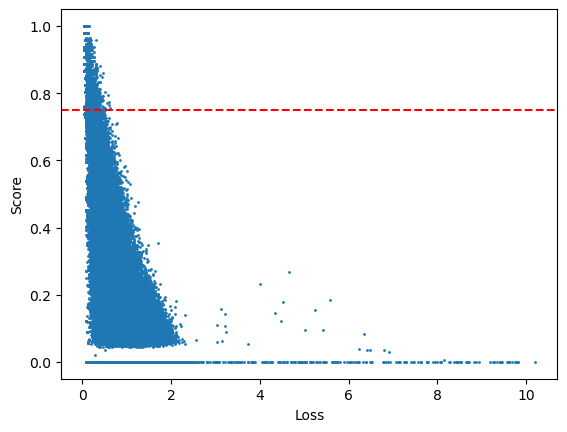

In [108]:
import json
import pandas as pd
import matplotlib.pyplot as plt

scores = "tmp/europarl/nl/nl-100-100-2.7B/bleu_scores/sorted_compl_bleu_scores.jsonl"
losses = "tmp/europarl/nl/nl-100-100-2.7B/losses/decoded/sorted_compl_losses.jsonl"
# Load the data
with open(scores, 'r') as f:
    scores_data = [json.loads(line) for line in f]
with open(losses, 'r') as f:
    losses_data = [json.loads(line) for line in f]

# Convert to pandas DataFrame
scores_df = pd.json_normalize(scores_data, 'scores', ['exid'])
losses_df = pd.json_normalize(losses_data, 'losses', ['exid'])

# Merge the two DataFrames
merged_df = pd.merge(scores_df, losses_df, on=['exid', 'trial'])

# Plot the data
plt.scatter(merged_df['loss'], merged_df['score'], s=1)
plt.axhline(y=0.75, color='r', linestyle='--')
plt.xlabel('Loss')
plt.ylabel('Score')
plt.show()